## **PRACTICA MACHINE LEARNING - CARLOS MERCADAL - MIAX 7** 

Antes de empezar, importamos todas las librerías que vamos a utilizar a lo largo del código.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from PIL import Image
from mpl_finance import candlestick2_ohlc
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

 ### **Ejercicio 1**

Se requiere generar un modelo que clasifique un patrón de doble suelo y mostrar los resultados que muestren que dicho modelo es mejor que la aleatoriedad. Para ello vamos a ir detallando paso a paso el procedimiento que hemos seguido.

**1) Etiquetar las ventanas temporales del IBEX como ejemplos positivos y negativos con el notebook de etiquetado. Se sugiere tener al menos unos 60 gráficos.**

Para el etiquetado de las ventanas temporales del Ibex hemos utilizado el código que nos facilitó Tomás. En el enunciado se nos sugiere tener al menos 60 gráficos. Por simplicidad las etiquetas están basadas en 1 (doble suelo), 2(doble techo), y 0(sin patron).

- Abrimos el pickle con los datos del IBEX que nos han facilitado y vemos qué pinta tienen.

In [2]:
#Abrimos el pickle que nos han facilitado
with open('benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)

ibex = bm['ibex']

In [3]:
#Vemos que pinta tiene
ibex.head()

,close,high,low,open,vol
2000-01-03,11610.0,11881.8,11574.4,11846.6,60107000.0
2000-01-04,11206.6,11530.0,11159.8,11499.5,62539000.0
2000-01-05,10863.1,11068.1,10824.9,11206.6,68153000.0
2000-01-07,11102.4,11137.9,10882.7,10963.4,144207000.0
2000-01-10,11173.3,11364.3,11120.6,11363.8,133817000.0


- Cargamos los datos con las etiquetas, vemos qué pinta tienen y el número de ejemplos:

In [4]:
#cargamos ejemplos doble suelo
ejemplos_doble_suelo = pd.read_csv('ejemplos_doble_suelo.csv')
ejemplos_doble_suelo = ejemplos_doble_suelo.iloc[:,1:]

#cargamos ejemplos doble techo
ejemplos_doble_techo = pd.read_csv('ejemplos_doble_techo.csv')
ejemplos_doble_techo = ejemplos_doble_techo.iloc[:,1:]

#cargamos ejemplos sin patron
ejemplos_sin_patron = pd.read_csv('ejemplos_sin_patron.csv')
ejemplos_sin_patron.columns = ['fechas', 'etiquetas']
ejemplos_sin_patron = ejemplos_sin_patron[:110]

In [5]:
print(f'Tenemos {len(ejemplos_doble_suelo)} gráficos')
ejemplos_doble_suelo.head()

Tenemos 110 gráficos


,fechas,etiquetas
0,2007-08-30,1
1,2014-06-23,1
2,2007-02-13,1
3,2007-02-09,1
4,2002-01-24,1


In [6]:
print(f'Tenemos {len(ejemplos_doble_techo)} gráficos')
ejemplos_doble_techo.head()

Tenemos 72 gráficos


,fechas,etiquetas
0,2002-02-21,2.0
1,2014-08-19,2.0
2,2015-11-13,2.0
3,2014-08-28,2.0
4,2004-02-16,2.0


In [7]:
print(f'Tenemos {len(ejemplos_sin_patron)} gráficos')
ejemplos_sin_patron.head()

Tenemos 110 gráficos


,fechas,etiquetas
0,2008-01-18,0.0
1,2012-11-30,0.0
2,2010-12-23,0.0
3,2016-03-02,0.0
4,2017-06-12,0.0


- Mostramos un ejemplo al azar que ha sido etiquetado:

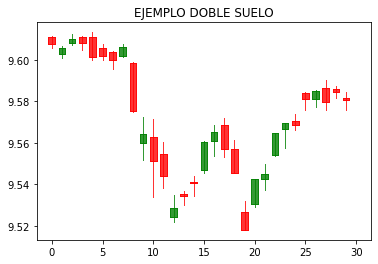

,close,high,low,open,vol
2007-02-15,9.607565,9.611684,9.605674,9.611101,18.807479
2007-02-16,9.605836,9.606590,9.600861,9.602855,19.575683
2007-02-19,9.610176,9.612319,9.607296,9.608062,18.694206
2007-02-20,9.608183,9.611610,9.604846,9.611269,19.015945
2007-02-21,9.601625,9.613376,9.600035,9.611235,19.057411


In [8]:
fecha = ejemplos_doble_suelo.fechas.sample().values[0]
inicio_ventana = ibex.index.get_loc(fecha)
fin_ventana = inicio_ventana + 30
datos_ventana = ibex.iloc[inicio_ventana:fin_ventana]
datos_ventana = np.log(datos_ventana)

fig, ax = plt.subplots(figsize=(6,4))
_ = candlestick2_ohlc(ax, datos_ventana.open, datos_ventana.high,
                          datos_ventana.low, datos_ventana.close,
                          colorup='g', colordown='r', width=0.66, alpha=0.8)

ax.set_title('EJEMPLO DOBLE SUELO', fontsize = 12)
plt.show()
datos_ventana.head()

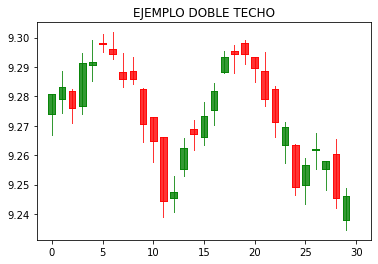

,close,high,low,open,vol
2011-04-01,9.280790,9.280790,9.266777,9.273991,19.173558
2011-04-04,9.283228,9.288588,9.274413,9.278952,18.968681
2011-04-05,9.275997,9.282596,9.270927,9.281944,19.221323
2011-04-06,9.291469,9.294893,9.274132,9.276727,19.302032
2011-04-07,9.291837,9.299093,9.285299,9.290703,19.431343


In [9]:
fecha = ejemplos_doble_techo.fechas.sample().values[0]
inicio_ventana = ibex.index.get_loc(fecha)
fin_ventana = inicio_ventana + 30
datos_ventana = ibex.iloc[inicio_ventana:fin_ventana]
datos_ventana = np.log(datos_ventana)

fig, ax = plt.subplots(figsize=(6,4))
_ = candlestick2_ohlc(ax, datos_ventana.open, datos_ventana.high,
                          datos_ventana.low, datos_ventana.close,
                          colorup='g', colordown='r', width=0.66, alpha=0.8)


ax.set_title('EJEMPLO DOBLE TECHO', fontsize = 12)

plt.show()
datos_ventana.head()

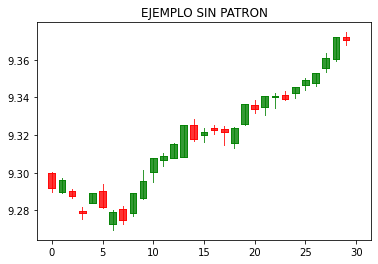

,close,high,low,open,vol
2006-01-13,9.291985,9.300455,9.289660,9.300035,18.927191
2006-01-16,9.296371,9.297050,9.289299,9.289697,18.594668
2006-01-17,9.287885,9.291367,9.286848,9.290491,18.993929
2006-01-18,9.278756,9.281796,9.275585,9.279773,18.978752
2006-01-19,9.289290,9.289290,9.283907,9.284028,19.044188


In [10]:
fecha = ejemplos_sin_patron.fechas.sample().values[0]
inicio_ventana = ibex.index.get_loc(fecha)
fin_ventana = inicio_ventana + 30
datos_ventana = ibex.iloc[inicio_ventana:fin_ventana]
datos_ventana = np.log(datos_ventana)

fig, ax = plt.subplots(figsize=(6,4))
_ = candlestick2_ohlc(ax, datos_ventana.open, datos_ventana.high,
                          datos_ventana.low, datos_ventana.close,
                          colorup='g', colordown='r', width=0.66, alpha=0.8)

ax.set_title('EJEMPLO SIN PATRON', fontsize = 12)

plt.show()
datos_ventana.head()

**2) Generar características que se consideren interesantes para reconocer el patrón a partir de los datos de la ventana temporal.**


Para generar características hemos creado una clase que se llama "generador_características". Esta clase se va a encargar de generarnos las características que vamos a utilizar tanto para los ejemplos de doble suelo como los ejemplos de doble techo. No obstante, puesto que en la primera parte sólo se nos dice que detectemos dobles suelos, vamos a quedarnos únicamente con las que definen el doble suelo. 

   ##### **A) Descripción de la clase "generador_características":**

Describimos todas y cada una de las funciones que se encuentran dentro de la clase, y las características que generan.

1) Funciones principales: 
    - **__init __**: Va a ser el constructor de la clase, al que le vamos a pasar como parámetros de entrada "self", los datos del ibex, los ejemplos etiquetados, y un umbral que vamos a utilizar para la generación de alguna de las características.
    - **generador_ventanas**: Se va a encargar de construir las ventanas que definen cada ejemplo, y tendrá como entrada "self", y la fecha a partir de la cual debe generar la ventana.
    - **generador_parte_uno**: Esta va a ser la función que va a juntar todas las funciones de la clase. Va a generarnos un data-frame con las features y los targets a partir de las distintas funciones que componen la clase. Parte de un data-frame vacío y posteriormente vamos iterando por las fechas contenidas en cada ejemplo para ir generando ventanas y calcular cada una de las características que describen cada ventana. Finalmente, hacemos un shuffle para ordenar aleatoriamente los distintos ejemplos obtenidos.
    - **generador_parte_dos**: Hace lo mismo que la función anterior, pero en este caso tiene en cuenta los datos de doble techo.
    - **generador_datos_test**: Esta función genera lo mismo que la parte uno y dos, pero el código está flexibilizado para poder pasar una serie temporal de datos que sean completamente nuevos (i.e. EUROSTOXX).


2) Funciones generadoras de características:

    - **calculo_dias**: Calcula el número de días entre el máximo y el mínimo "close" de la serie temporal.
    - **max_min_first**: Calcula si primero sucede el máximo o el mínimo de la serie. Si primero sucede el mínimo le ponemos un 1, si primero sucede el máximo le ponemos un 0.
    - **bottom_detector**: Esta función va a devolver el número de suelos encontrados. Idealmente se busca encontrar un patrón que genere una 'W'. Para ello, usaremos una función llamada "soportes" que primero va a analizar todas las velas de la ventana temporal buscando soportes. Los soportes los va a encontrar siempre que tengamos 5 velas con el siguiente patrón: 

            - El low de la Vela(X-1) mayor o igual que la vela(X) & vela(X-2) mayor o igual que la vela(X-1) & vela(X+1) mayor o igual a la vela(X) & Vela(X+1) menor o igual a la vela(X+2). El objetivo es encontrar un patrón con forma de V.
            
       Consideraciones a tener en cuenta:
             - Si no se encuentra ningún soporte, el resultado será 0.
             - Buscamos el mínimo de la serie temporal y establecemos un umbral. Buscamos el soporte que tenga el mínimo más bajo y lo comparamos con un umbral, establecido como el mínimo de la serie temporal + un porcentaje. Si el mínimo de dicho soporte es superior al umbral establecido,   entonces descartamos que pueda ser un suelo. 
             
    - **tops_detector**: Es muy parecido al bottom detector, pero intenta buscar doble techos usando la mísma técnica. Esta vez usamos una función que busque resistencias usando el mismo sistema de 5 velas que en el apartado anterior, pero cambiando los signos para buscar una V invertida. El umbral de "seguridad" lo estableceremos usando el máximo de la serie temporal + un porcentaje y lo comparamos con el pico máximo de las resistencias encontradas. Si el pico es menor al umbral, descartamos que pueda ser un techo. 
    
    - **breakout_double_top**: Esta característica será dependiente de la tops detector. Puesto que las figuras de doble suelo/techo sirven para detectar cambios de tendencia; vamos a utilizar esta característica para ver si esto sucede o no. La idea es que una vez hemos encontrado al menos dos resistencias, vamos a calcular el mínimo de la serie existente entre ambos picos. De este modo, encontraremos lo que se conoce como "neckline",un valor que vamos a utilizar para buscar una posible rotura de tendencia. Una vez tenemos el neckline, buscamos si hay algún valor en la serie posterior a la última resistencia que sea menor al neckline. Si se produce, diremos que hay un cambio de tendencia bajista y que se ha producido un "breakout". 
    
           Consideraciones a tener en cuenta:
           
                - Si tenemos más de dos resistencias, nos quedaremos con la primera y la última.
                

    - **breakout_double_bottom**: Esta característica será dependiente de la bottoms detector. La lógica que hay detrás es la misma que la utilizada para el breakout double top, pero en este caso buscamos roturas de tendencia alcista a partir del neckline. Tendremos en cuenta las mismas consideraciones que en el apartado anterior.
    
    - **distancia_media**: Esta característica calcula la distancia media que hay entre los datos de cierre y la media móvil de 30 días calculada para la misma ventana. Se trata de calcular la diferencia entre los cierres de cada día y la media móvil para cada día, luego calculamos la media de estos valores.
    - **green_candles**: Calculamos el número de días positivos.
    - **red_candles**: Calculamos el número de días negativos. 
    - **rentabilidad_ventana**: Calculamos la rentabilidad de la ventana.

In [11]:
class generador_caracteristicas:
    
    def __init__(self, datos, ejemplos_sin_patron, ejemplos_doble_suelo, ejemplos_doble_techo, umbral_lows, umbral_highs):
        'Estbalecemos el constructor de la clase'
        self.umbral_lows = umbral_lows
        self.umbral_highs = umbral_highs
        self.datos_benchmark = datos
        self.datos_ejemplos_parte_uno = pd.concat([ejemplos_doble_suelo, ejemplos_sin_patron])
        self.datos_ejemplos_parte_dos = pd.concat([ejemplos_doble_suelo, ejemplos_sin_patron, ejemplos_doble_techo])
            
    def generador_ventanas(self, fecha):
        'Generamos las ventanas con y sin patron'
        inicio_ventana = self.datos_benchmark.index.get_loc(fecha)
        fin_ventana = inicio_ventana + 30
        datos_ventana = self.datos_benchmark.iloc[inicio_ventana:fin_ventana]
        datos_ventana = np.log(datos_ventana)
        return datos_ventana
        
        
    def calculo_dias(self):
        'Calculo el número de dias entre el máximo y el mínimo de la serie temporal.'
        minimo = np.where(self.datos_ventana.low == self.datos_ventana.low.min())[0][0]
        maximo = np.where(self.datos_ventana.high == self.datos_ventana.high.max())[0][0]
        dias = maximo - minimo
        if dias < 0:
            dias = -dias
        return dias

    def max_min_first(self):
        'Calculo primero aparece el mínimo o el máximo de la serie.'
        minimo = np.where(self.datos_ventana.low == self.datos_ventana.low.min())[0][0]
        maximo = np.where(self.datos_ventana.high == self.datos_ventana.high.max())[0][0]
        if minimo < maximo:
            min_first = 1
            return min_first
        if maximo < minimo:
            max_first = 0
            return max_first

    def bottom_detector(self):
        'Buscamos el número de suelos que aparecen en la serie temporal'
        
        #Genero una función que detecta soportes
        def support(candle_low, i):
            'detecta si hay un soporte'
            if candle_low[i] <= candle_low[i-1] and candle_low[i-1] <= candle_low[i-2] and candle_low[i] <= candle_low[i+1] and candle_low[i+1] <= candle_low[i+2]:
                support = True
                return(support)
        
        #No quiero trabajar con los candle lows porque a veces se producen valores muy bajos; prefiero trabajar con los valores de Close y Open.
        #Me quedo con el valor más pequeño entre close y open para cada día.
        candle_low = self.datos_ventana.loc[:,['close','open']].min(axis=1)
        umbral_lows = self.umbral_lows
        #Genero una lista en la que voy a guardar los soportes detectados
        levels = []
        for i in range(2,candle_low.shape[0]-2):
            if support(candle_low, i) == True:
                levels.append(i)
        #Miro si se han detectado soportes, si no hay ninguno damos el resultado.        
        if len(levels) == 0:
            self.bottoms = []
            bottoms = 0
            return bottoms
        
        #Si aparecen más de dos soportes me quedo con los dos con el mínimo más pequeño.
        lowest = pd.Series([candle_low[i] for i in range(len(levels))], dtype='float64').sort_values()[:2]    
        bottoms = pd.Series(levels, dtype='int')[lowest.index].sort_values().tolist()
        
        #Si sólo hay un soporte, devuelvo el resultado
        if len(levels) == 1:
            bottoms = 1
            self.bottoms = []
            return bottoms
                            
        #Descarto los soportes detectados si vemos que el mínimo del soporte más bajo está por encima del umbral determinado.
        if candle_low[bottoms].min() > candle_low.min() * umbral_lows:
            bottoms = 0
            self.bottoms = []
            return bottoms
        self.bottoms = bottoms            
        return len(bottoms)
    
    def tops_detector(self):
        'Buscamos el número de techos que aparecen en la serie temporal'
        
        #Genero una función que detecta resistencias
        def resistance(candle_high, i):
            'detecta si hay una resistencia'
            if candle_high[i] > candle_high[i-1] and candle_high[i-1] > candle_high[i-2] and candle_high[i] > candle_high[i+1] and candle_high[i+1] > candle_high[i+2]:
                resistance = True
                return(resistance)
           
        #No quiero trabajar con los candle high porque a veces se producen valores muy altos; prefiero trabajar con los valores de Close y Open.
        #Me quedo con el valor más grande entre close y open para cada día.
        candle_max = self.datos_ventana.loc[:,['close','open']].max(axis=1)
        umbral_highs = self.umbral_highs
        #Genero una lista en la que voy a guardar las resistencias detectadas
        levels = []
        for i in range(2,candle_max.shape[0]-2):
            if resistance(candle_max, i) == True:
                levels.append(i)

        if len(levels) == 0:
            self.tops = []
            tops = 0
            return tops         
        
        #Si aparecen más de dos resistencias me quedo con las dos con el máximo más grande.
        highest = pd.Series([candle_max[i] for i in range(len(levels))], dtype='float64').sort_values()[:2]    
        tops = pd.Series(levels, dtype='int')[highest.index].sort_values().tolist()
        
        if len(levels) == 1:
            tops = 1
            self.tops = []
            return tops
        
        #Descarto las resistencias detectadas si vemos que el máximo de la resistencia más grande está por debajo del umbral determinado.
        if candle_max[tops].max() < candle_max.max() * umbral_highs:
            tops = 0
            self.tops = []
            return tops
        self.tops = tops
        return len(tops)
    
    def breakout_double_top(self):       
        'Calculo si hay un breakout en la M (double top)'
        
        candle_min = self.datos_ventana.loc[:,['close','open']].min(axis=1)
        
        #Compruebo que tenga techos
        if len(self.tops) == 0:
            breakout = 0
            return breakout
        
        tops = pd.Series(self.tops)
        days_betw = tops.max() - tops.min()
        
        #Comrpuebo que entre los techos detectados hayan pasado al menos 3 días
        if days_betw > 3:
            #Buscamos el neckline para luego comprobar si hay breakout
            neckline = candle_min[tops.min():tops.max()].min()
            prices_after_range = candle_min[tops.max():]
            if any(prices_after_range <= neckline):
                breakout = 1
            else:
                breakout = 0
        else:
            breakout = 0
        
        return breakout

    def breakout_double_bottom(self):
        'Calculo si hay un breakout en la W (double bottom)'
        
        candle_max = self.datos_ventana.loc[:,['close','open']].max(axis=1)
        
        #Compruebo que tenga suelos
        if len(self.bottoms) == 0:
            breakout = 0
            return breakout
        
        bottoms = pd.Series(self.bottoms)
        days_betw = bottoms.max() - bottoms.min()
        
        #Comrpuebo que entre los suelos detectados hayan pasado al menos 3 días 
        if days_betw > 3:
            #Buscamos el neckline para luego comprobar si hay breakout
            neckline = candle_max[bottoms.min():bottoms.max()].max()
            prices_after_range = candle_max[bottoms.max():]
            if any(prices_after_range >= neckline):
                breakout = 1
            else:
                breakout = 0
        else:
            breakout = 0
        
        return breakout
    
    def distancia_media(self):
        'Calculo la diferencia entre la media rolling de 30 días y los precios de cierre, hacemos la media'
        window_rolling = np.log(self.datos_benchmark.close.rolling(30).mean().dropna())[self.datos_ventana.index]
        distancia_media = np.mean(window_rolling - self.datos_ventana.close)
        return distancia_media
    
    def green_candles(self):
        'Calculo el número de días positivos y días negativos en la serie.'
        green = np.sum(self.datos_ventana.close > self.datos_ventana.open)
        return green
    
    def red_candles(self):
        'Calculo el número de días positivos y días negativos en la serie.'
        red = np.sum(self.datos_ventana.close < self.datos_ventana.open)
        return red
    
    def rentabilidad_ventana(self):
        'Calculo la rentabilidad de la ventana temporal'
        
        inicio = np.log(self.datos_ventana.open)[0]
        fin = np.log(self.datos_ventana.close)[-1]
        rentabilidad = (inicio - fin)/fin
        return rentabilidad
        
    def generador_parte_uno(self):
        'Genero un data-frame utilizando todas las funciones anteriores para la parte uno'
        
        dataset = pd.DataFrame(index = range(0,len(self.datos_ejemplos_parte_uno)), columns = ['dias máximo vs mínimo', 'primero mínimo vs máximo', 'bottoms',
                                                                 'breakout bottoms', 'distancia_media', 'dias positivos', 'dias negativos','rentabilidad_ventana', 'target'])
        for i in range(0,len(self.datos_ejemplos_parte_uno)):
            
            fecha = self.datos_ejemplos_parte_uno.fechas.iloc[i]
            etiqueta = self.datos_ejemplos_parte_uno.etiquetas.iloc[i]
            
            self.datos_ventana = self.generador_ventanas(fecha)
                    
            dataset.loc[i, 'dias máximo vs mínimo'] = self.calculo_dias()
            dataset.loc[i, 'primero mínimo vs máximo'] = self.max_min_first()
            dataset.loc[i, 'bottoms'] = self.bottom_detector()
            dataset.loc[i, 'breakout bottoms'] = self.breakout_double_bottom()
            dataset.loc[i, 'distancia_media'] = self.distancia_media()
            dataset.loc[i, 'dias positivos'] = self.green_candles()
            dataset.loc[i, 'dias negativos'] = self.red_candles()
            dataset.loc[i, 'rentabilidad_ventana'] = self.rentabilidad_ventana()
            dataset.loc[i, 'target'] = etiqueta
        
        dataset = dataset.sample(frac = 1)
        features = dataset.iloc[:, :-1]
        target = dataset.loc[:,'target'].astype(int).squeeze()
        target = target.replace({1:'yes', 0:'no'})
        
        return features, target
    
    def generador_parte_dos(self):
        'Genero un data-frame utilizando todas las funciones anteriores para la parte dos'
        
        dataset = pd.DataFrame(index = range(0,len(self.datos_ejemplos_parte_dos)), columns = ['dias máximo vs mínimo', 'primero mínimo vs máximo', 'bottoms',
                                                                                      'tops',  'breakout tops',
                                                                 'breakout bottoms','distancia_media', 'dias positivos', 'dias negativos', 'rentabilidad_ventana', 'target'])
        
        for i in range(0,len(self.datos_ejemplos_parte_dos)):
            
            fecha = self.datos_ejemplos_parte_dos.fechas.iloc[i]
            etiqueta = self.datos_ejemplos_parte_dos.etiquetas.iloc[i]
            
            self.datos_ventana = self.generador_ventanas(fecha)
            
        
            dataset.loc[i, 'dias máximo vs mínimo'] = self.calculo_dias()
            dataset.loc[i, 'primero mínimo vs máximo'] = self.max_min_first()
            dataset.loc[i, 'tops'] = self.tops_detector()
            dataset.loc[i, 'breakout tops'] = self.breakout_double_top()
            dataset.loc[i, 'bottoms'] = self.bottom_detector()
            dataset.loc[i, 'breakout bottoms'] = self.breakout_double_bottom()
            dataset.loc[i, 'distancia_media'] = self.distancia_media()
            dataset.loc[i, 'dias positivos'] = self.green_candles()
            dataset.loc[i, 'dias negativos'] = self.red_candles()
            dataset.loc[i, 'rentabilidad_ventana'] = self.rentabilidad_ventana()
            dataset.loc[i, 'target'] = etiqueta
        
        dataset = dataset.sample(frac = 1)
        features = dataset.iloc[:, :-1]
        target = dataset.loc[:,'target'].astype(int).squeeze()
        target = target.replace({1: 'Doble Suelo', 2:'Doble Techo', 0:'Sin Patron'})
                
        return features, target
    
    def generador_datos_test(self, parte_uno):
        'Genero un data-frame utilizando todas las funciones anteriores para datos del eurostoxx'
        
        if parte_uno == True:
            
            dataset = pd.DataFrame(index = range(1000), columns = ['dias máximo vs mínimo', 'primero mínimo vs máximo', 'bottoms',
                                                                 'breakout bottoms','distancia_media','dias positivos', 'dias negativos', 'rentabilidad_ventana', 'target'])
        
            ventanas = []
            for i in range(1000):

                fecha = self.datos_benchmark[30:-30].sample().index[0]

                self.datos_ventana = self.generador_ventanas(fecha)
                ventanas.append(self.datos_ventana)
                dataset.loc[i, 'dias máximo vs mínimo'] = self.calculo_dias()
                dataset.loc[i, 'primero mínimo vs máximo'] = self.max_min_first()
                dataset.loc[i, 'bottoms'] = self.bottom_detector()
                dataset.loc[i, 'breakout bottoms'] = self.breakout_double_bottom()
                dataset.loc[i, 'distancia_media'] = self.distancia_media()
                dataset.loc[i, 'dias positivos'] = self.green_candles()
                dataset.loc[i, 'dias negativos'] = self.red_candles()
                dataset.loc[i, 'rentabilidad_ventana'] = self.rentabilidad_ventana()

            dataset = dataset.sample(frac = 1)
            features = dataset.iloc[:, :-1]

            return features, ventanas
        
        else:            
        
            dataset = pd.DataFrame(index = range(1000), columns = ['dias máximo vs mínimo', 'primero mínimo vs máximo', 'bottoms',
                                                                                          'tops',  'breakout tops',
                                                                     'breakout bottoms','distancia_media','dias positivos', 'dias negativos', 'rentabilidad_ventana', 'target'])

            ventanas = []
            for i in range(1000):

                fecha = self.datos_benchmark[30:-30].sample().index[0]

                self.datos_ventana = self.generador_ventanas(fecha)
                ventanas.append(self.datos_ventana)
                dataset.loc[i, 'dias máximo vs mínimo'] = self.calculo_dias()
                dataset.loc[i, 'primero mínimo vs máximo'] = self.max_min_first()
                dataset.loc[i, 'tops'] = self.tops_detector()
                dataset.loc[i, 'breakout tops'] = self.breakout_double_top()
                dataset.loc[i, 'bottoms'] = self.bottom_detector()
                dataset.loc[i, 'breakout bottoms'] = self.breakout_double_bottom()
                dataset.loc[i, 'distancia_media'] = self.distancia_media()
                dataset.loc[i, 'dias positivos'] = self.green_candles()
                dataset.loc[i, 'dias negativos'] = self.red_candles()
                dataset.loc[i, 'rentabilidad_ventana'] = self.rentabilidad_ventana()

            dataset = dataset.sample(frac = 1)
            features = dataset.iloc[:, :-1]

            return features, ventanas

- Ejecutamos la clase generadora de características, concretamente la función generadora_parte_uno, que genera las características para sin patron y doble suelo. Vemos qué pinta tienen las características y los targets obtenidos:

In [12]:
features_generator = generador_caracteristicas(ibex, ejemplos_sin_patron, ejemplos_doble_suelo, ejemplos_doble_techo, umbral_lows = 1.0003, umbral_highs = 0.9997)
features, target= features_generator.generador_parte_uno()

In [13]:
features

,dias máximo vs mínimo,primero mínimo vs máximo,bottoms,breakout bottoms,distancia_media,dias positivos,dias negativos,rentabilidad_ventana
81,16,1,1,0,-0.012952,15,15,-0.004359
33,22,1,2,1,0.00598,15,15,-0.002386
124,29,1,0,0,-0.021951,18,12,-0.003062
45,19,0,2,1,-0.033557,16,14,-0.001383
165,19,0,2,0,0.01438,12,18,0.002571
...,...,...,...,...,...,...,...,...
154,26,1,1,0,-0.013719,16,14,-0.001614
100,16,1,1,0,-0.024255,18,12,-0.002073
78,23,1,2,1,-0.014405,14,16,-0.002549
162,16,1,0,0,-0.003441,15,15,-0.001171


In [14]:
target

81     yes
33     yes
124     no
45     yes
165     no
      ... 
154     no
100    yes
78     yes
162     no
131     no
Name: target, Length: 220, dtype: object

**B) Normalizado y Escalado de las características.**
Una vez tenemos las características generadas, será necesario normalizarlas y escalarlas para que el algoritmo pueda identificar bien los distintos datos dentro de una misma característica. De este modo, obtendremos los datos dentro de una misma característica centrados en 0 y con la misma desviación típica. Ejecutamos la función y vemos qué pinta tiene.

In [15]:
def feature_scaler(features):
    'Escalamos las features'
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_features = pd.DataFrame(scaled_features, columns=features.columns)
    return scaled_features

In [16]:
features = feature_scaler(features)
features.head()

,dias máximo vs mínimo,primero mínimo vs máximo,bottoms,breakout bottoms,distancia_media,dias positivos,dias negativos,rentabilidad_ventana
0,-0.155285,0.921271,-0.116606,-0.697486,-0.523066,-0.036968,0.038687,-1.281242
1,0.830180,0.921271,1.049457,1.433721,0.105962,-0.036968,0.038687,-0.664966
2,1.979890,0.921271,-1.282669,-0.697486,-0.822042,1.072071,-1.071457,-0.876064
3,0.337447,-1.085457,1.049457,1.433721,-1.207644,0.332712,-0.331361,-0.351641
4,0.337447,-1.085457,1.049457,-0.697486,0.385038,-1.146006,1.148831,0.883538


In [17]:
features.describe().round(3)

,dias máximo vs mínimo,primero mínimo vs máximo,bottoms,breakout bottoms,distancia_media,dias positivos,dias negativos,rentabilidad_ventana
count,220.000,220.000,220.000,220.000,220.000,220.000,220.000,220.000
mean,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000
std,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002
min,-2.455,-1.085,-1.283,-0.697,-2.488,-2.625,-3.292,-2.646
25%,-0.648,-1.085,-1.283,-0.697,-0.642,-0.776,-0.331,-0.675
50%,0.009,0.921,-0.117,-0.697,-0.092,-0.037,0.039,-0.125
75%,0.666,0.921,1.049,1.434,0.380,0.333,0.779,0.464
max,1.980,0.921,1.049,1.434,3.531,3.290,2.629,3.191


**3) Entrenamos uno de los modelos vistos en clase.**

Puesto que no se especifica ningún modelo en concreto, vamos a utilizar un metaclasificador *Random Forest* para entrenar nuestro modelo.

- En primer lugar dividimos nuestro dataset en training y test usando la función train_test_split de sklearn y vemos como quedan divididos nuestros datos:

In [18]:
x_train, x_test, y_train, y_test = train_test_split(features.values, target.values, test_size=0.4, stratify= target.values)

dataset_samples = pd.DataFrame(index = ['Training_sample', 'Test_sample'], columns = ['Yes', 'No', 'Total %'])

vals, counts = np.unique(y_train, return_counts=True)

dataset_samples.loc['Training_sample', 'Yes'] = counts[1]
dataset_samples.loc['Training_sample', 'No'] = counts[0]
dataset_samples.loc['Training_sample', 'Total %'] = y_train.shape[0]/target.shape[0]

vals, counts = np.unique(y_test, return_counts=True)

dataset_samples.loc['Test_sample', 'Yes'] = counts[1]
dataset_samples.loc['Test_sample', 'No'] = counts[0]
dataset_samples.loc['Test_sample', 'Total %'] = y_test.shape[0]/target.shape[0]

dataset_samples

,Yes,No,Total %
Training_sample,66,66,0.6
Test_sample,44,44,0.4


- Preparamos nuestro modelo random forest con n estimadores:

In [19]:
rforest = RandomForestClassifier(n_estimators=20)

- Vamos a optimizar el modelo mediante validación cruzada jugando con el número de características, número de estimadores, profundidad del arbol, y ejemplos por hoja como hiperparámetros. Para ello vamos a utilizar la función GridSearchCV de sklearn, que va a realizar una optimización exhaustiva de los hiperparámetros proporcionados con validación cruzada:

In [20]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
#Determinamos los hiperparámetros
param_grid = {
    'max_features': [2, 3, 4, 5, 7],
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [2, 4, 6, 8]
}
#Inicializamos la función gridsearchcv
grid_cv = GridSearchCV(estimator = rforest, 
                       param_grid = param_grid,
                       scoring = 'accuracy',
                       cv = kfold, 
                       verbose=0)


- Entrenamos el modelo y lo optimizamos con validación cruzada:

In [21]:
_ = grid_cv.fit(x_train, y_train)

#Imprimimos los mejores parámetros para nuestro modelo optimizado
grid_cv.best_params_

{'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 50}

- Ejecutamos nuestro modelo en training y test para posteriormente analizar los resultados:

In [22]:
best_rf = grid_cv.best_estimator_
train_predicted = best_rf.predict(x_train)
test_predicted = best_rf.predict(x_test)

**4) Reportar los resultados de evaluación.**
Vamos a utilizar el paquete sklearn metrics para obtener lo siguiente:

    - Una matriz de confusión:  
    - Resultado de accuracy y AUROC
    - Una curva ROC

- Preparo un data-frame con la matriz de confusión para train y para test, posteriormente la analizamos:

In [23]:
matriz_confusion_train= confusion_matrix(y_train, train_predicted)
matriz_confusion_test = confusion_matrix(y_test, test_predicted)

matriz_confusion_train = pd.DataFrame(matriz_confusion_train, index = ['Predicted Positive', 'Predicted Negative'], 
                                      columns = ['Actual Positive', 'Actual Negative'])

matriz_confusion_test = pd.DataFrame(matriz_confusion_test, index = ['Predicted Positive', 'Predicted Negative'], 
                                      columns = ['Actual Positive', 'Actual Negative'])

In [24]:
print('''Matriz de confusión en dataset entrenamiento
''')

matriz_confusion_train

Matriz de confusión en dataset entrenamiento



,Actual Positive,Actual Negative
Predicted Positive,56,10
Predicted Negative,12,54


In [25]:
print('''Matriz de confusión en dataset test
''')

matriz_confusion_test

Matriz de confusión en dataset test



,Actual Positive,Actual Negative
Predicted Positive,31,13
Predicted Negative,11,33


Gracias a las matrices de confusión generadas podemos observar fácilmente los falsos positivos y falsos negativos. Para que nuestro modelo pueda generalizar bien con los datos de test, es bueno encontrar algunos falsos negativos y positivos en training; si no encontráramos ninguno sería un indicio de overfitting, ya que nuestro modelo se habría adaptado completamente a nuestros datos de entrenamiento y no generalizaría bien con nuevos datos.

- Preparo un data-frame con los datos de accuracy y AUROC tanto en train como en test. Posteriormente la analizamos:

In [26]:
#Sacamos las probabilidades para el AUROC

train_prob = best_rf.predict_proba(x_train)
train_posprob = train_prob[:,1]

test_prob = best_rf.predict_proba(x_test)
test_posprob = test_prob[:,1]

In [27]:
#Preparo un data-frame con los resultados de accuracy y AUROC tanto en train como en test

results = pd.DataFrame(index = [['accuracy', 'AUROC']] , columns = [['Train','Test']])
results.loc['accuracy', 'Train'] = accuracy_score(y_train, train_predicted)
results.loc['accuracy', 'Test'] = accuracy_score(y_test, test_predicted)
results.loc['AUROC', 'Train'] = roc_auc_score(y_train, train_posprob)
results.loc['AUROC', 'Test'] = roc_auc_score(y_test, test_posprob)

In [28]:
results

,Train,Test
accuracy,0.833333,0.727273
AUROC,0.935491,0.820248


Como comentábamos anteriormente, vemos que el accuracy en train no es excesivamente elevado, lo cual es un buen indicio de que no estamos sufriendo overfitting. También es imporante ver que la diferencia entre train y test no seá especialmente elevada, ya que esto implica que nuestro modelo generaliza bien. Idealmente deberíamos intentar buscar un accuracy parecido tanto en training como en test. La AUROC también tiene buena pinta, ya que al ser superior a 0.5 nos indica que el modelo ha aprendido y que, por tanto, es mejor que la aleatoriedad. 

No obstante, para que podamos validar mejor los resultados de nuestro modelo, podemos utilizar la validación cruzada. Ésta se va a encargar de ejecutar nuestro modelo en distintas particiones de nuestros datos, y nos quedaremos con la media de los resultados de cada Kfold.

In [29]:
#Evaluamos nuestro modelo mediante validaicón cruzada
scoring = ['accuracy', 'roc_auc']
scores = cross_validate(best_rf, features, target, scoring=scoring, cv=4)
results_part_one = pd.DataFrame(scores)
results_part_one

,fit_time,score_time,test_accuracy,test_roc_auc
0,0.049998,0.011000,0.690909,0.760582
1,0.048884,0.010998,0.709091,0.842593
2,0.044999,0.010035,0.709091,0.792328
3,0.044968,0.011000,0.618182,0.723545


In [30]:
#Sacamos la media
results_part_one.mean()

fit_time         0.047212
score_time       0.010758
test_accuracy    0.681818
test_roc_auc     0.779762
dtype: float64

Observamos como tanto el accuracy como el AUROC disminuye con la validación cruzada respecto a los resultados enseñados anteriormente. Esto se debe a que al testear nuestro modelo con distintos datos (Kfolds) obtenemos resultados distintos. El objetivo es poner "trabas" a nuestro modelo partiendo de distintos datos para llegar a una evaluación más veraz y no fiarnos de una única ejecución.

- Pintamos una curva ROC:

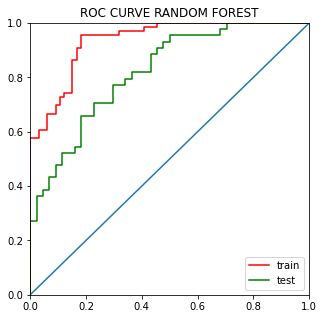

In [31]:
train_fpr, train_tpr, train_thr = roc_curve(y_train, train_posprob, pos_label='yes')
test_fpr, test_tpr, test_thr = roc_curve(y_test, test_posprob, pos_label='yes')

fig, ax = plt.subplots(figsize=(5,5))
plt.title('ROC CURVE RANDOM FOREST')
plt.plot(train_fpr, train_tpr, color='r', label='train')
plt.plot(test_fpr, test_tpr, color='g', label='test')
plt.plot([0,1],[0,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.0])
plt.legend(loc='lower right')
plt.savefig('decision_tree.png')

**5) Reportar la importancia de las características generadas.**

Para ello vamos a utilizar la importancia por permutación.

In [32]:
pimp_rforest = permutation_importance(best_rf, x_train, y_train, n_repeats=10)

In [33]:
imp_df = pd.DataFrame({'ft': features.columns,
                           'rforest_mean': pimp_rforest.importances_mean,
                           'rforest_std': pimp_rforest.importances_std,
                          })
imp_df.sort_values('rforest_mean', ascending=False, inplace=True)

imp_df_better = imp_df.iloc[:10]
   
imp_df_better

,ft,rforest_mean,rforest_std
0,dias máximo vs mínimo,0.069697,0.015076
3,breakout bottoms,0.066667,0.029883
4,distancia_media,0.041667,0.023776
2,bottoms,0.031818,0.014690
6,dias negativos,0.029545,0.011464
5,dias positivos,0.028030,0.016957
7,rentabilidad_ventana,0.025000,0.013143
1,primero mínimo vs máximo,0.014394,0.017092


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'dias máximo vs mínimo'),
  Text(1, 0, 'breakout bottoms'),
  Text(2, 0, 'distancia_media'),
  Text(3, 0, 'bottoms'),
  Text(4, 0, 'dias negativos'),
  Text(5, 0, 'dias positivos'),
  Text(6, 0, 'rentabilidad_ventana'),
  Text(7, 0, 'primero mínimo vs máximo')])

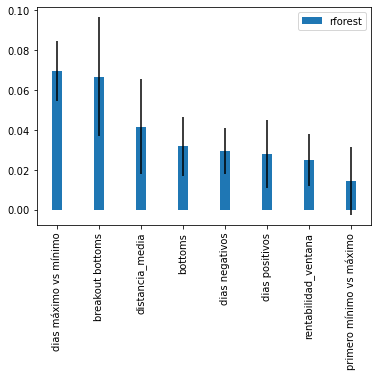

In [34]:
bw=0.25
plt.bar(np.arange(imp_df_better.shape[0]),
                  imp_df_better.rforest_mean,
                  yerr=imp_df_better.rforest_std,
                  width=bw,
                  tick_label=imp_df_better.ft,
                  )
plt.legend(['rforest'])
plt.xticks(rotation=90)

Gracias a la importancia por permutación vemos qué características han tenido un mayor impacto para nuestro modelo.

 ### **Ejercicio 2**

En esta parte se pide abordar el problema como una clasificación multiclase para que se puedan reconocer a la vez varias figuras técnicas. Un esquema sencillo sería tener por ejemplo doble suelo, doble techo y
sin patrón. Las tareas sugeridas son:



**1) Realizar los pasos del 1 al 3 de la primera iteración, pero teniendo las consideraciones requeridas para el problema multiclase.**


El conjunto de datos que vamos a utilizar en esta ocasión va a ser la unión de los ejemplos doble suelo, doble techo, y sin patrón. Para ello utilizaremos los csv importados al inicio de la práctica. Ejecutamos la clase generadora de características, concretamente la función generadora_parte_dos, que genera las características para sin patron, doble suelo y doble techo. En este caso las etiquetas serán 0, 1, 2. 

In [35]:
features_generator = generador_caracteristicas(ibex, ejemplos_sin_patron, ejemplos_doble_suelo, ejemplos_doble_techo, umbral_lows = 1.0003, umbral_highs = 0.9997)
features, target = features_generator.generador_parte_dos()
#Normalizamos las características
features = feature_scaler(features)

In [36]:
features.head()

,dias máximo vs mínimo,primero mínimo vs máximo,bottoms,tops,breakout tops,breakout bottoms,distancia_media,dias positivos,dias negativos,rentabilidad_ventana
0,-0.202014,1.006873,1.180301,1.029004,-0.651452,-0.593171,-0.457269,-1.078238,1.080218,-0.288114
1,1.087346,1.006873,0.035291,-0.149306,-0.651452,-0.593171,-0.460686,0.027777,-0.026532,-0.595436
2,1.087346,-0.993174,0.035291,1.029004,1.535032,-0.593171,3.068449,-1.078238,1.080218,2.810207
3,0.281496,1.006873,0.035291,-1.327617,-0.651452,-0.593171,0.138623,1.133791,-1.133281,0.064965
4,-0.524354,-0.993174,-1.109719,1.029004,1.535032,-0.593171,0.872978,-1.078238,1.080218,0.774666


In [37]:
target.head()

155     Sin Patron
126     Sin Patron
211     Sin Patron
52     Doble Suelo
285    Doble Techo
Name: target, dtype: object

In [38]:
features.describe().round(decimals=3)

,dias máximo vs mínimo,primero mínimo vs máximo,bottoms,tops,breakout tops,breakout bottoms,distancia_media,dias positivos,dias negativos,rentabilidad_ventana
count,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000
mean,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000
std,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002
min,-2.297,-0.993,-1.110,-1.328,-0.651,-0.593,-2.644,-2.553,-3.347,-2.963
25%,-0.686,-0.993,-1.110,-1.328,-0.651,-0.593,-0.625,-0.710,-0.395,-0.686
50%,-0.041,-0.993,0.035,-0.149,-0.651,-0.593,-0.162,0.028,-0.027,-0.039
75%,0.604,1.007,1.180,1.029,1.535,1.686,0.406,0.396,0.711,0.461
max,2.054,1.007,1.180,1.029,1.535,1.686,3.960,3.346,2.556,3.453


**2) Entrenar clasificadores utilizando 3 algoritmos diferentes, y elegir el mejor en función del accuracy estimado con una validación cruzada.**

Para entrenar los 3 clasificadores distintos hemos realizado una clase llamada "ml_clasificator" que vamos a desarrollar a continuación:


**EVALUACIÓN DE LOS MODELOS**: Para evaluar cada modelo, cogeremos los resultados obtenidos y se lo pasaremos al a función classification_report de sklearn, que nos devuelve el precision y recall en sus variables macro y average. Así mismo, también ejecutaremos la función cross_validation de sklearn para quedarnos con el accuracy medio de los kfolds de cada modelo, y escogeremos el mejor algoritmo en función del accuracy. 


##### **A) Modelos que hemos utilizado:**

1) *Metlaclasificador por votación*: 

Este modelo se trata de un metaclasificador que va a utilizar un arbol de decisión, un knn, y un clasificador bayesiano. El modelo usará los resultados obtenidos por los tres modelos y hará una votación para escoger el valor de salida, de modo que la clase ganadora será aquella en la que coincidan al menos dos de los tes modelos. 

Cada uno de los modelos va a realizar una optimización de sus hiperparámetros mediante validación cruzada con gridsearchcv, y nos devolverá, para cada modelo, la probabilidad asignada a cada clase. Una vez juntemos los resultados de los tres algoritmos, obtendremos las clases asignadas para cada ejemplo. Usaremos ese output a la hora de realizar la evaluación del modelo. 

2) *Random Forest*:

Metaclasificador random forest que va a optimizar sus hiperparámetros usando gridsearchcv. Nos va a devolver la clase con mayor probabilidad para cada ejemplo y la evaluación del modelo. 

3) *Bagging*:

Al igual que con el random forest, optimizaremos hiperparámetros y nos devolverá la clase con mayor probabilidad para cada ejemplo y la evaluación del modelo.


 ##### **B) Clase ml_classificator:**
 A continuación vamos a describir las distintas funciones que están dentro de la clase:
 
 -**init**: Va a ser el constructor de nuestra clase, y le vamos a pasar las features para doble suelo, sin patrón, y doble techo; así como el target con los que vamos a entrenar nuestro modelo. 
 
 -**data_samples**: Esta función se va a encargar de partir los datos en entrenamiento y test, para que todos los modelos tengan el mismo punto de partida. De este modo, todos los modelos van a empezar en igualdad de condiciones. Desde mi punto de vista, si este paso no se respeta, podría suceder que un modelo tenga unos datos de entrenamiento más "claros" o "fáciles" que otro. 
 
 -**decision_tree**: Esta función se encarga de entrenar y optimizar el arbol de decisión que va a formar parte del metlaclasificador por votación. Nos devuelve la evaluación del modelo a nivel individual y las probabilidades asignadas para cada clase en cada ejemplo. 
 
 -**knn**: Esta función se encarga de entrenar y optimizar el knn que va a formar parte del metlaclasificador por votación. Nos devuelve la evaluación del modelo a nivel individual y las probabilidades asignadas para cada clase en cada ejemplo. 
 
 -**n_bayes**: Esta función se encarga de entrenar y optimizar el modelo bayesiano que va a formar parte del metlaclasificador por votación. Nos devuelve la evaluación del modelo a nivel individual y las probabilidades asignadas para cada clase en cada ejemplo. 
 
 -**metaclasificador_por_votacion**: Esta función coge los resultados de los tres modelos anteriores y los une para que hagan una votación de la clase ganadora para cada ejemplo. Una vez tenemos todos los ejemplos y las clases asignadas, evaluamos el modelo comparándolo con el target. 
 
 -**random_forest**: Esta función va a entrenar y optimizar el modelo random forest, y nos va a devolver las clases asignadas y la evaluación del modelo.
 
 -**bagging**: Esta función va a entrenar y optimizar el modelo bagging y nos va a devolver las clases asignadas y la evaluación del modelo. 
 
 -**model_training**: Esta va a ser la función principal. Llama a las funciones anteriores, de forma que genera la partición de los datos, y luego ejecuta cada modelo por separado. Por último, escoge el modelo que haya arrojado un mejor accuracy y guarda todos los resultados obtenidos en un diccionario. 
 

In [39]:
class ml_classificator:
    
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def data_samples(self): 

        'Separa las features y targets en train, validación y sample'
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.features.values, self.target.values, test_size=0.4, stratify= self.target.values)
        
        

    def decision_tree(self):

        #Preparamos el modelo y lo entrenamos.
        tree = DecisionTreeClassifier(min_samples_leaf=4, max_depth = None, random_state = 1)

        #Establecemos unos parámetros a optimizar mediante un GridSearch con cross validation
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        param_grid = {
        'max_features': [2, 3, 5, 7],
        'max_depth': [2, 3, 4],
        'min_samples_leaf': [2, 4, 6, 8]
        }

        grid_cv = GridSearchCV(estimator = tree, 
                           param_grid = param_grid, 
                           cv = kfold,
                           scoring = 'accuracy',    
                           verbose=0)

        #Optimizamos el modelo en el set de validación
        _ = grid_cv.fit(self.x_train, self.y_train)

        #Sacamos los mejores parámetros y los establecemos como parámetros de entrada
        mejores_parametros = grid_cv.best_params_
        best_dtree = grid_cv.best_estimator_
        self.best_dtree = best_dtree

        #Ejecutamos el modelo
        self.train_predicted = best_dtree.predict(self.x_train)
        self.test_predicted = best_dtree.predict(self.x_test)
        
        #Guardo el resultado para el metaclasificador votacion
        self.tree_test_predicted = self.test_predicted
        self.tree_train_predicted = self.train_predicted

        #Sacamos las probabilidades de acierto para el cálculo de la curva AUROC

        train_prob = best_dtree.predict_proba(self.x_train)
        train_posprob = train_prob[:,1]

        test_prob = best_dtree.predict_proba(self.x_test)
        self.test_posprob = test_prob[:,1]

        #Sacamos las métricas de los resultados
        scoring = ['accuracy']
        scores = cross_validate(best_dtree, self.features, self.target, scoring=scoring, cv=4)
        results_part_one = pd.DataFrame(scores)
        accuracy = results_part_one.mean()[2].round(3)      

        return accuracy, self.test_posprob


    def KNN(self):

        #Preparamos el modelo y lo entrenamos.
        knn = KNeighborsClassifier()
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

        #Establecemos unos parámetros a optimizar mediante un GridSearch con cross validation
        param_grid = {'weights': ['uniform', 'distance'], 
                      'n_neighbors': [int(np.sqrt(len(features)).round())]}

        grid_cv = GridSearchCV(estimator = knn, 
                           param_grid = param_grid, 
                           cv = kfold,
                           scoring = 'accuracy',
                           verbose=0)

        #Optimizamos el modelo en el set de validación
        _ = grid_cv.fit(self.x_train, self.y_train)

        #Sacamos los mejores parámetros y los establecemos como parámetros de entrada
        mejores_parametros = grid_cv.best_params_
        best_knn = grid_cv.best_estimator_
        self.best_knn = best_knn

        #Ejecutamos el modelo
        self.train_predicted = best_knn.predict(self.x_train)
        self.test_predicted = best_knn.predict(self.x_test)
        
        #Guardo el resultado para el metaclasificador votacion
        self.knn_test_predicted = self.test_predicted
        self.knn_train_predicted = self.train_predicted

        #Sacamos las probabilidades de acierto para el cálculo de la curva AUROC

        train_prob = best_knn.predict_proba(self.x_train)
        train_posprob = train_prob[:,1]

        test_prob = best_knn.predict_proba(self.x_test)
        self.test_posprob = test_prob[:,1]

        #Sacamos las métricas de los resultados
        scoring = ['accuracy']
        scores = cross_validate(best_knn, self.features, self.target, scoring=scoring, cv=4)
        results_part_one = pd.DataFrame(scores)
        accuracy = results_part_one.mean()[2].round(3)     

        return accuracy, self.test_posprob

    def nbayes(self):

        #Preparamos el modelo y lo entrenamos.
        nbayes = GaussianNB()
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

        #Establecemos unos parámetros a optimizar mediante un GridSearch con cross validation
        param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

        grid_cv = GridSearchCV(estimator = nbayes, 
                           param_grid = param_grid, 
                           cv = kfold,
                           scoring = 'accuracy',
                           verbose = 0) 

        #Optimizamos el modelo en el set de validación
        _ = grid_cv.fit(self.x_train, self.y_train)

        #Sacamos los mejores parámetros y los establecemos como parámetros de entrada
        mejores_parametros = grid_cv.best_params_
        best_bayes = grid_cv.best_estimator_
        self.best_bayes = best_bayes

        #Ejecutamos el modelo
        self.train_predicted = best_bayes.predict(self.x_train)
        self.test_predicted = best_bayes.predict(self.x_test)
        
        #Guardo el resultado para el metaclasificador votacion
        self.nbayes_test_predicted = self.test_predicted
        self.nbayes_train_predicted = self.train_predicted

        #Sacamos las probabilidades de acierto para el cálculo de la curva AUROC

        train_prob = best_bayes.predict_proba(self.x_train)
        train_posprob = train_prob[:,1]

        test_prob = best_bayes.predict_proba(self.x_test)
        self.test_posprob = test_prob[:,1]

        #Sacamos las métricas de los resultados
        scoring = ['accuracy']
        scores = cross_validate(best_bayes, self.features, self.target, scoring=scoring, cv=4)
        results_part_one = pd.DataFrame(scores)
        accuracy = results_part_one.mean()[2].round(3)      

        return accuracy, self.test_posprob
    
    def metaclasificador_votacion(self):
        
        #Scamos los resultados de accuracy obtenidos mediante validación cruzada y ejecutamos cada uno de los modelos
        accuracy_tree , _ = self.decision_tree()
        accuracy_knn , _ = self.KNN()
        accuracy_bayes , _ = self.nbayes()
        
        #Extraemos los resultados de los modelos en fase train
        tree_train_predicted = self.tree_train_predicted
        knn_train_predicted = self.knn_train_predicted
        nbayes_train_predicted = self.nbayes_train_predicted
        
        #Extraemos los resultados de los modelos en fase test
        tree_test_predicted = self.tree_test_predicted
        knn_test_predicted = self.knn_test_predicted
        nbayes_test_predicted = self.nbayes_test_predicted
        
        #Los juntamos en un data frame
        all_test_pred = pd.DataFrame({
            'tree': tree_test_predicted,
            'knn': knn_test_predicted,
            'nbayes': nbayes_test_predicted
        })
        
        all_train_pred = pd.DataFrame({
            'tree': tree_train_predicted,
            'knn': knn_train_predicted,
            'nbayes': nbayes_train_predicted
        })
        
        #Realizamos la votación 
        meta_test_pred = all_test_pred.mode(axis=1)[0]       
        meta_train_pred = all_train_pred.mode(axis=1)[0]
        
        #calculamos el accuracy medio de cada uno de los modelos obtenidos mediante validación cruzada
        accuracy_votacion = (accuracy_tree + accuracy_knn  + accuracy_bayes)/3
        
        self.train_predicted = meta_train_pred
        self.test_predicted = meta_test_pred
        
        model_evalutaion = classification_report(self.y_test, self.test_predicted)      

        return model_evalutaion, accuracy_votacion
    
    
    def random_forest(self):
        
        rforest = RandomForestClassifier(n_estimators=20, random_state = 1)
        
        #Entrenamos el modelo random forest y lo optmizamos mediante gridsearchcv
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        param_grid = {
            'max_features': [2, 3, 4, 5, 7],
            'n_estimators': [20, 50, 100, 150],
            'max_depth': [2, 3, 4],
            'min_samples_leaf': [2, 4, 6, 8]
        }
        grid_cv = GridSearchCV(estimator = rforest, 
                               param_grid = param_grid,
                               scoring = 'accuracy',
                               cv = kfold, 
                               verbose=0)
        
        #Optimizamos los hiperparámetros
        _ = grid_cv.fit(self.x_train, self.y_train)
        best_rf = grid_cv.best_estimator_
        self.best_rf = best_rf
        
        #Ejecutamos el modelo
        self.train_predicted = best_rf.predict(self.x_train)
        self.test_predicted = best_rf.predict(self.x_test)
        
        #Sacamos las evaluaciones del modelo
        model_evalutaion = classification_report(self.y_test, self.test_predicted) 
        
        #Obtenemos el accuracy mediante validación cruzada
        scoring = ['accuracy']
        scores = cross_validate(best_rf, self.features, self.target, scoring=scoring, cv=4)
        results_part_one = pd.DataFrame(scores)
        results = results_part_one.mean()[2].round(3) 
        
        return model_evalutaion, results
        
    def bagging(self):
        
        #Inicializamos el metaclasificador bagging usando un arbol de decisión como modelo base
        tree = DecisionTreeClassifier(min_samples_leaf=4, max_depth = None)
        bagg = BaggingClassifier(base_estimator= tree, n_estimators=10, random_state=1)
        
        #Optimizamos el modelo mediante gridsearchcv
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        param_grid = {
            'max_features': [2, 3, 4, 5, 7],
            'n_estimators': [20, 50, 100, 150],
            
        }
        
        grid_cv = GridSearchCV(estimator = bagg, 
                               param_grid = param_grid,
                               scoring = 'accuracy',
                               cv = kfold, 
                               verbose=0)
        
        _ = grid_cv.fit(self.x_train, self.y_train)
        best_bagg = grid_cv.best_estimator_
        self.best_bagg = best_bagg
        
        #Ejecutamos el modelo
        self.train_predicted = best_bagg.predict(self.x_train)
        self.test_predicted = best_bagg.predict(self.x_test)
        
        model_evalutaion = classification_report(self.y_test, self.test_predicted) 
        
        #Obtenemos el accuracy mediante validación cruzada
        scoring = ['accuracy']
        scores = cross_validate(best_bagg, self.features, self.target, scoring=scoring, cv=4)
        results_part_one = pd.DataFrame(scores)
        results = results_part_one.mean()[2].round(3)
        
        return model_evalutaion, results

    def model_training(self):
        
        #Entrenamos todos los modelos y obtenemos sus resultados
        data_samples = self.data_samples()
        vota_model_evalutaion, accuracy_votacion = self.metaclasificador_votacion()
        rforest_model_evalutaion, accuracy_rforest = self.random_forest()
        bagging_model_evalutaion, accuracy_bagging = self.bagging()
        
        #Escogemos al ganador en función del accuracy medio de cada modelo sacado mediante validación cruzada
        max_acc = max([accuracy_votacion, accuracy_rforest, accuracy_bagging])
        
        if accuracy_votacion == max_acc:
            ganador = 'votacion'
        
        if accuracy_rforest == max_acc:
            ganador = 'rforest'
        
        if accuracy_bagging == max_acc:
            ganador = 'bagging'
        
        results = {'ganador':ganador,
                    'votacion': {'model_evaluation': vota_model_evalutaion,
                               'accuracy': accuracy_votacion},
                   'rforest': {'model_evaluation': rforest_model_evalutaion,
                               'accuracy': accuracy_rforest},
                   'bagging': {'model_evaluation': bagging_model_evalutaion,
                               'accuracy': accuracy_bagging},
                   
                   'predictors':{'votacion': [self.best_bayes, self.best_dtree, self.best_knn],
                                'rforest': self.best_rf,
                                'bagging': self.best_bagg}
            }
                                                                                
        return results    

- Ejecutamos el modelo 

In [40]:
results = ml_classificator(features, target).model_training()

**3) Reportar la evaluación del mejor modelo sobre un conjunto de test separado. Aquí se debe incluir precisión y sensibilidad, por clase y en sus versiones micro-average y macro-average.**



- Obtenemos los resultados del modelo, y sacamos el ganador y el accuracy obtenido

In [41]:
#Devuelve el algoritmo ganador
winner = results['ganador']
#Devuelve los modelos entrenados, lo usaremos para el siguiente apartado
predictors = results['predictors']
accuracy = results[winner]['accuracy']
print(f'El modelo que ha ganado es: {winner}, con un accuracy de {accuracy}')

El modelo que ha ganado es: bagging, con un accuracy de 0.678


- Evaluamos el modelo que ha ganado mediante la funcion classification_report de sklearn. Nos devuelve en pantalla el precision y recall del agoritmo ganador para cada una de las clases en sus versiones macro average y micro average. Destacar que con la función classification report, cuando le pasamos todas las clases, el accuracy representa el micro_average. 

Extracto de la documentación de la funcion: 

*"Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise and would be the same for all metrics. "*

In [42]:
print(results[winner]['model_evaluation'])

              precision    recall  f1-score   support

 Doble Suelo       0.68      0.59      0.63        44
 Doble Techo       0.76      0.90      0.83        29
  Sin Patron       0.60      0.61      0.61        44

    accuracy                           0.68       117
   macro avg       0.68      0.70      0.69       117
weighted avg       0.67      0.68      0.67       117



**4) Utilizar el modelo para identificar 5 patrones de cada clase en la serie histórica del EuroStoxx. Por ejemplo, se puede iterar sobre las ventanas temporales y elegir las de mayor confianza en la predicción de cada clase.**

- Vamos a cargar un CSV con datos del eurostoxx.

In [43]:
eurostoxx = pd.read_csv('datos_eurostoxx.csv')
eurostoxx.columns = ['fechas', 'open', 'high', 'low', 'close', 'vol']
eurostoxx.index = eurostoxx.fechas
eurostoxx = eurostoxx.iloc[:,1:]

In [44]:
#Imprimimos los datos del eurostoxx
eurostoxx.head()

,open,high,low,close,vol
fechas,,,,,
2010-01-04,4713.30,4781.32,4713.30,4781.32,0
2010-01-05,4779.49,4793.68,4763.38,4772.71,0
2010-01-06,4770.38,4779.79,4748.45,4768.44,0
2010-01-07,4753.34,4775.15,4721.13,4764.75,0
2010-01-08,4773.67,4792.07,4743.18,4781.40,0


- Vamos a pasar los datos del eurostoxx a la función generadora de características. Esta función está definida al inicio del notebook, escogera 1000 ventanas aleatorias de la serie del eurostoxx y generará características para cada una de las ventanas. Posteriormente las vamos a normalizar.

In [45]:
features_generator = generador_caracteristicas(eurostoxx, ejemplos_sin_patron, ejemplos_doble_suelo, ejemplos_doble_techo, umbral_lows = 1.0003, umbral_highs = 0.9997)
caracteristicas_eurostoxx, ventanas = features_generator.generador_datos_test(parte_uno = False)

In [46]:
#Mostramos una ventana aleatoria
ventanas[0].head()

,open,high,low,close,vol
fechas,,,,,
2015-02-20,8.777950,8.781308,8.769658,8.779945,-inf
2015-02-23,8.785737,8.790908,8.782160,8.788234,-inf
2015-02-24,8.789485,8.798332,8.785636,8.796021,-inf
2015-02-25,8.795375,8.796566,8.790940,8.794520,-inf
2015-02-26,8.794640,8.804232,8.793225,8.803839,-inf


In [47]:
#Mostramos las características generadas
caracteristicas_eurostoxx.head()

,dias máximo vs mínimo,primero mínimo vs máximo,bottoms,tops,breakout tops,breakout bottoms,distancia_media,dias positivos,dias negativos,rentabilidad_ventana
33,16,1,1,0,0,0,-0.000347,21,9,-0.001046
867,22,1,0,0,0,0,-0.029102,20,10,-0.002393
135,27,1,0,1,0,0,-0.018384,17,13,-0.002524
289,12,0,2,2,0,0,-0.005345,15,15,-0.000129
681,28,1,0,0,0,0,-0.032007,19,11,-0.005504


In [48]:
#Normalizamos
caracteristicas_eurostoxx = feature_scaler(caracteristicas_eurostoxx)

In [49]:
caracteristicas_eurostoxx.describe().round(3)

,dias máximo vs mínimo,primero mínimo vs máximo,bottoms,tops,breakout tops,breakout bottoms,distancia_media,dias positivos,dias negativos,rentabilidad_ventana
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.323,-1.154,-1.157,-1.088,-0.505,-0.563,-2.120,-2.553,-2.316,-2.970
25%,-0.896,-1.154,-1.157,-1.088,-0.505,-0.563,-0.615,-0.660,-0.824,-0.642
50%,0.104,0.867,-0.018,0.056,-0.505,-0.563,-0.110,0.097,-0.077,-0.132
75%,0.817,0.867,1.120,1.200,-0.505,-0.563,0.486,0.476,0.669,0.442
max,1.674,0.867,1.120,1.200,1.981,1.775,6.414,2.369,2.535,7.069


- Genero una función "pattern detector" a la cual le voy a pasar el modelo ganador entrenado anteriormente y las características de la serie histórica del eurostoxx. La función va a filtrar el modelo a seleccionar en función de quien haya ganado, y lo ejecutará para clasificar las ventanas temporales del eurostoxx.

In [50]:
def pattern_detector(winner, predictors, x_test):
       
    best_bayes = predictors['votacion'][0] 
    best_dtree = predictors['votacion'][1] 
    best_knn = predictors['votacion'][2] 
    best_bagg = predictors['bagging']
    best_rf = predictors['rforest']
        
    if winner == 'votacion':
        nbayes_test_predicted = best_bayes.predict(x_test)
        bayes_prob = best_bayes.predict_proba(x_test)
        
        tree_test_predicted = best_dtree.predict(x_test)
        tree_prob = best_dtree.predict_proba(x_test)
        
        knn_test_predicted = best_knn.predict(x_test)
        knn_prob = best_knn.predict_proba(x_test)

        all_test_pred = pd.DataFrame({
        'tree': tree_test_predicted,
        'knn': knn_test_predicted,
        'nbayes': nbayes_test_predicted
        })

        prediccion = all_test_pred.mode(axis=1)[0]
        pred_probability = (bayes_prob + tree_prob + knn_prob) / 3

    if winner == 'bagging':
        prediccion = best_bagg.predict(x_test)
        pred_probability = best_bagg.predict_proba(x_test)
        
    if winner == 'rforest':
        prediccion = best_rf.predict(x_test)
        pred_probability = best_rf.predict_proba(x_test)
        
    
    resultado = pd.DataFrame()
    resultado['etiqueta'] = prediccion
    resultado['prob'] = pred_probability.max(axis=1)

    return resultado
    

- Ejecutamos la función pattern detector para que nos clasifique los datos nuevos.

In [51]:
resultado = pattern_detector(winner, predictors, caracteristicas_eurostoxx)

- Una vez tenemos todas las ventanas clasificadas, nos quedamos con 5 ejemplos para cada una de las clases. Para ello, nos vamos a quedar con los 5 ejemplos por clase que tengan una mayor probabilidad de acierto. 

In [52]:
best_results = {}

best_results['SIN PATRON'] = resultado['prob'][resultado['etiqueta'] == 'Sin Patron'].sort_values(ascending = False)[:5]
best_results['DOBLE SUELO'] = resultado['prob'][resultado['etiqueta'] == 'Doble Suelo'].sort_values(ascending = False)[:5]
best_results['DOBLE TECHO'] = resultado['prob'][resultado['etiqueta'] == 'Doble Techo'].sort_values(ascending = False)[:5]

- Imprimimos los resultados

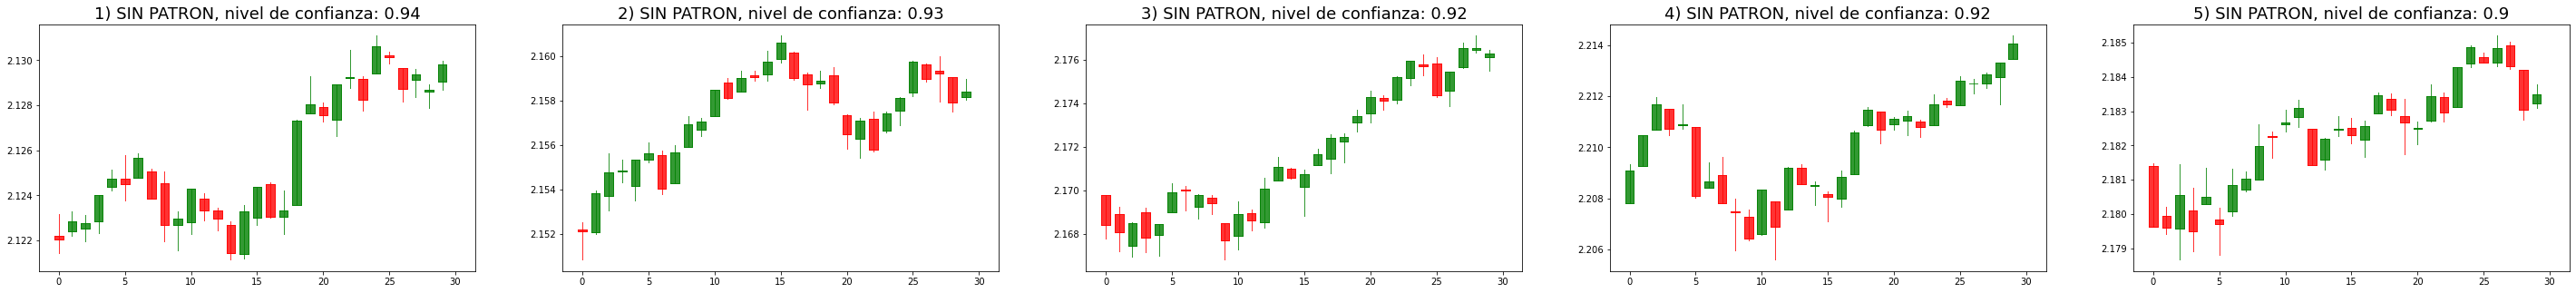

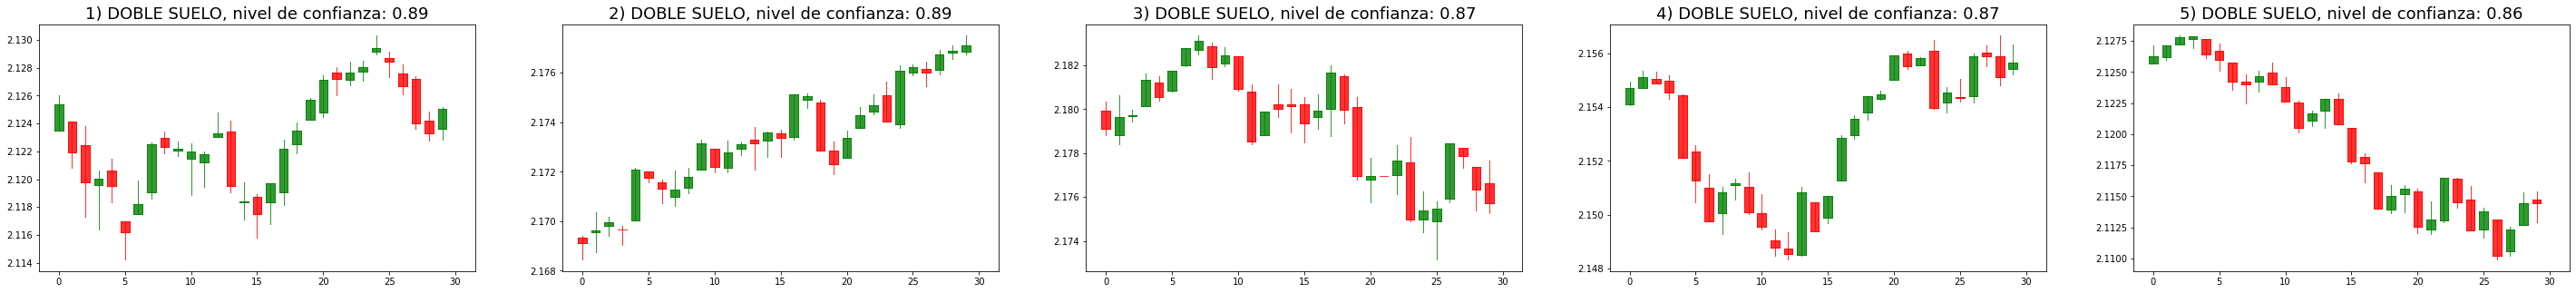

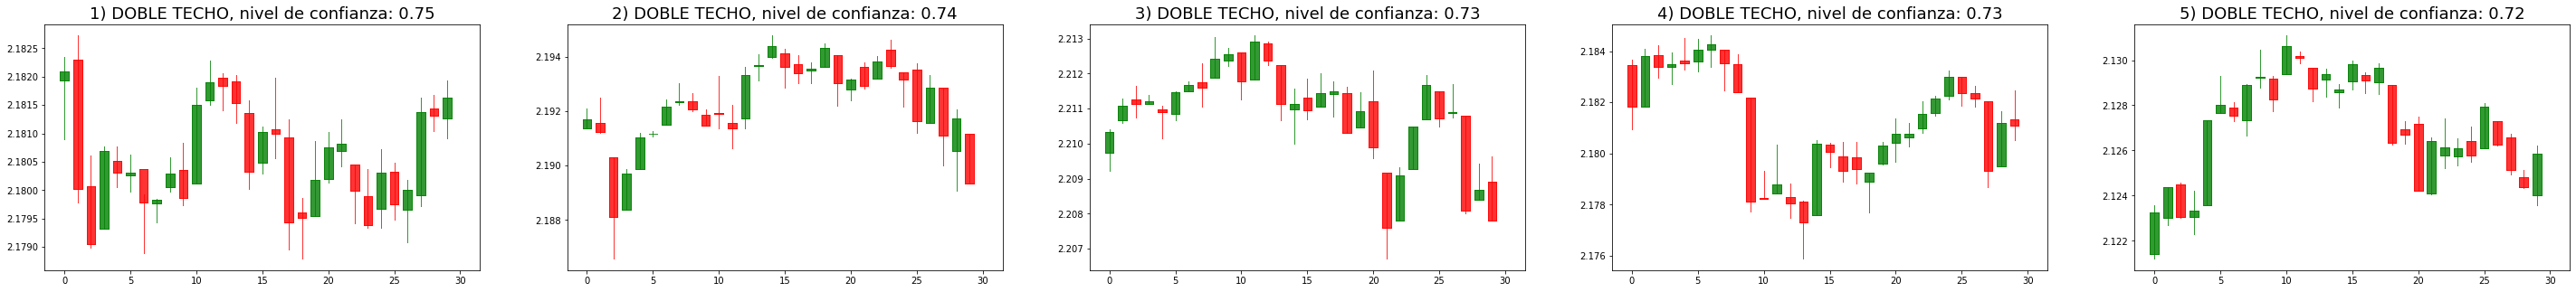

In [53]:
patrones = ['SIN PATRON', 'DOBLE SUELO', 'DOBLE TECHO']

for patron in patrones:
    fig, ax = plt.subplots(1, 5)
    fig.set_size_inches(50,5)
    k = 0
    for i in best_results[patron].index:

        confianza = best_results[patron].iloc[k].round(2)
        datos_ventana = np.log(ventanas[i])
        _ = candlestick2_ohlc(ax[k], datos_ventana.open, datos_ventana.high,
                                  datos_ventana.low, datos_ventana.close,
                                  colorup='g', colordown='r', width=0.66, alpha=0.8)
        ax[k].set_title(f'{k+1}) {patron}, nivel de confianza: {confianza}', fontsize = 18)

        k +=1

 ### **Ejercicio 3**

En esta parte se abordará el problema desde un enfoque de aprendizaje semi-supervisado. Dado que el etiquetado es un proceso manual y relativamente lento, planteamos etiquetar un conjunto de entrenamiento más amplio utilizando un algoritmo de co-training. Los pasos sugeridos son:

**1) Utilizar un conjunto etiquetado en las partes anteriores y desarrollar un conjunto independiente de nuevas caracter´ısticas. Si se dispone de más de 5 características se podrían partir en 2 subconjuntos.**

Para el ejercicio 3, voy a utilizar el modelo de clasificación binaria del ejercicio 1. Para ello, vamos a generar las características del apartado 1 en las cuales sólo tenemos en cuenta los dobles suelos y sin patrón.

In [66]:
features_generator = generador_caracteristicas(ibex, ejemplos_sin_patron, ejemplos_doble_suelo, ejemplos_doble_techo, umbral_lows = 1.0003, umbral_highs = 0.9997)
features, target = features_generator.generador_parte_uno()
features = feature_scaler(features)

In [67]:
features.columns

Index(['dias máximo vs mínimo', 'primero mínimo vs máximo', 'bottoms',
       'breakout bottoms', 'distancia_media', 'dias positivos',
       'dias negativos', 'rentabilidad_ventana'],
      dtype='object')

- Dividimos las características en dos subconjuntos. Las que sean dependientes irán dentro del mismo subconjunto.

In [68]:
x_train_uno = features.loc[:,['dias máximo vs mínimo', 'primero mínimo vs máximo', 'dias positivos', 'dias negativos']]
x_train_dos = features.loc[:,['bottoms', 'distancia_media', 'breakout bottoms', 'rentabilidad_ventana']]
training_data = [x_train_uno, x_train_dos]

**2) Generar un conjunto S' a etiquetar sacando ventanas aleatorias de la serie.**

In [69]:
features_generator = generador_caracteristicas(ibex, ejemplos_sin_patron, ejemplos_doble_suelo, ejemplos_doble_techo, umbral_lows = 1.001, umbral_highs = 0.998)
subconjunto_sin_etiquetar, ventanas = features_generator.generador_datos_test(parte_uno = True)
subconjunto_sin_etiquetar = feature_scaler(subconjunto_sin_etiquetar)


**3) Entrenar dos modelos, uno con cada grupo de características, y etiquetar un subconjunto S’ según la clase con mayor confianza en ambos modelos. Asumir ahora, que S’ etiquetado junto con las etiquetas iniciales es el nuevo conjunto de entrenamiento, y repetir el proceso para un número pequeño de iteraciones.**

**A) CLASE COTRAINING**:

El objetivo de la clase cotraining es entrenar dos modelos de cotraining con el dataset original, un modelo tendrá como características "x_train_uno", y el otro modelo tendrá como características "x_train_dos". Cada modelo se va a entrenar usando unas características distintas, y nos devolverá las probabilidades asignadas para cada una de las clases. De éstas, quedará asignada la clase que haya obtenido una mayor probabilidad de éxito. 

Una vez haya hecho una primera iteración, vamos a pasarle nuevos datos que nunca haya visto (subconjunto_sin_etiquetar) y tendrá que clasificarlos. Una vez clasificados siguiendo el procedimiento anterior, éstos datos se unirán al dataset original. De este modo, para la segunda iteración, ya no usará únicamente los datos del dataset original etiquetado, si no que se entrenará usando el nuevo conjunto de datos etiquetado. 

El objetivo es que tenga un mayor número de ejemplos etiquetados para poder entrenar posteriormente nuestro modelo y así ganar mayor precisión a la hora de predecir las clases. 

Las **funciones** de la clase cotraining son:

-**init**: Será el constructor de la clase y le vamos a pasar los datos de training, los datos de test como subconjunto sin etiquetar, y el target.
-**model_training**: Esta función va a entrenar dos random forests, cada uno de ellos usando las características correspondientes a cada subconjunto. Para entrenar el modelo va a utilizar los datos de training, mientras que para predecir va a usar los datos de test (subconjunto sin etiquetar). Los modelos optimizarán sus hiperparámetros con gridsearchcv y nos devolverá sus predicciones para cada clase en formato de probabilidad. 

-**etiquetadora_cotraining**: Esta función cogerá los resultados de ambos modelos entrenados y escogerá la clase con mayor probabilidad para cada uno de los ejemplos sobre los datos de test (subconjunto sin etiquetar). Estos datos serán añadidos al dataset original para cada subconjunto de características, y las etiquetas nuevas se juntarán a las etiquetas originales; aumentando así el dataset de entrenamiento. 

-**main_function**: Esta será la función principal, va a coger el subconjunto sin etiquetar y lo va a dividir en subconjuntos de 10 en 10. Para cada subconjunto de 10 ejemplos, separaremos las características en x_test_uno, y x_test_dos. Posteriormente llamaremos al model training para que entrene los dos modelos y haga las predicciones para esos 10 ejemplos. Seguidamente llamaremos a la etiquetadora cotraining para que trate los resultados y genere un nuevo dataset. Repetiremos el proceso cuantas veces deseemos para generar nuevas etiquetas de 10 en 10. 

In [70]:
class cotraining:
    
    def __init__(self, training_data, test_data, target):
        self.training_data = training_data
        self.new_data = test_data
        self.target = target    
    
    def model_training(self):
        predicciones = []
        
        for i in range(0,2):
            
            x_train = self.training_data[i]
            x_test = self.test_data[i]
            
            #Entrenamos el modelo
            rforest = RandomForestClassifier(n_estimators=20)
            kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
            param_grid = {
                'max_features': [2, 3, 4],
                'n_estimators': [20, 50, 100],
                'max_depth': [2, 3, 4],
            }
            grid_cv = GridSearchCV(estimator = rforest, 
                                   param_grid = param_grid,
                                   scoring = 'accuracy',
                                   cv = kfold, 
                                   verbose=0)

            _ = grid_cv.fit(x_train, self.target)

            best_rf = grid_cv.best_estimator_
            prediccion = best_rf.predict(x_test)
            test_prob = best_rf.predict_proba(x_test)

            resultado = pd.DataFrame()
            resultado['etiqueta'] = prediccion
            resultado['prob'] = test_prob.max(axis=1)
            predicciones.append(resultado)
               
        return predicciones

    def etiquetadora_cotraining(self):

        resultados_uno = self.predicciones[0]
        resultados_dos = self.predicciones[1]
        label_1 = resultados_uno[resultados_uno.prob > resultados_dos.prob]
        label_2 = resultados_dos[resultados_uno.prob < resultados_dos.prob]
        target_y_test = pd.concat([label_1, label_2]).sort_index()

        #Actualizamos los datos de entrenamiento
        x_train_uno = pd.concat([self.training_data[0], self.test_data[0]])
        x_train_uno.index = range(0,len(x_train_uno))
        self.training_data[0] = x_train_uno

        x_train_dos = pd.concat([self.training_data[1], self.test_data[1]])
        x_train_dos.index = range(0,len(x_train_dos))
        self.training_data[1] = x_train_dos

        #Actualizamos etiquetas de entrenamiento
        new_target = pd.concat([self.target, target_y_test.loc[:,'etiqueta']])
        self.target = new_target
        
        return  target_y_test.loc[:,'etiqueta']
    
    def main_function(self):
        
        data_split = [(i, i + 10) for i in range(0,len(self.new_data), 10)]
        target_test_data = pd.DataFrame()
        
        for a,b in data_split[:20]:
            
            x_test_uno = self.new_data.loc[a:b,['dias máximo vs mínimo', 'primero mínimo vs máximo', 'dias positivos', 'dias negativos']]
            x_test_dos = self.new_data.loc[a:b,['bottoms', 'distancia_media', 'breakout bottoms', 'rentabilidad_ventana']]
            self.test_data = [x_test_uno, x_test_dos]
            self.predicciones = self.model_training()
            target_y_test = self.etiquetadora_cotraining()
            
            target_test_data = pd.concat([target_test_data, target_y_test])
            target_test_data.index = range(0, len(target_test_data))
        
        new_training_dataset = pd.concat([self.training_data[0], self.training_data[1]], axis = 1)
        resultados = {
            'nuevas_etiquetas': self.target,
            'datos_training': new_training_dataset,
        }
        
        return resultados 

- Ejecutamos el modelo cotraining para que genere 200 etiquetas nuevas.

In [71]:
modelo_cotraining = cotraining(training_data, subconjunto_sin_etiquetar, target)

In [72]:
resultados = modelo_cotraining.main_function()

- Mostramos el nuevo dataset de entrenamiento con las nuevas etiquetas

In [73]:
new_training_dataset = resultados['datos_training']
new_training_dataset

,dias máximo vs mínimo,primero mínimo vs máximo,dias positivos,dias negativos,bottoms,distancia_media,breakout bottoms,rentabilidad_ventana
0,-1.304995,-1.085457,0.332712,-0.331361,-1.282669,-0.586132,-0.697486,-0.417298
1,1.815645,-1.085457,-1.146006,1.148831,-1.282669,0.394462,-0.697486,0.793705
2,-0.155285,0.921271,1.072071,-1.071457,-0.116606,-0.898598,-0.697486,-0.567274
3,0.830180,0.921271,-0.406647,0.408735,-1.282669,-0.030264,-0.697486,-0.815867
4,-1.140751,0.921271,0.332712,-0.331361,-1.282669,-0.514376,-0.697486,-0.026954
...,...,...,...,...,...,...,...,...
435,0.324917,1.016130,0.745973,-0.738968,-0.062183,-0.493525,-0.498437,-0.365718
436,-1.264271,-0.984126,-0.756491,0.774535,1.133647,-0.434547,2.006272,0.041673
437,1.625161,1.016130,1.497206,-1.495719,-1.258013,-0.778896,-0.498437,-0.956590
438,1.336218,-0.984126,-0.380875,0.396159,-1.258013,2.422868,-0.498437,0.524637


In [77]:
new_target = resultados['nuevas_etiquetas']
new_target

153     no
114     no
100    yes
103    yes
62     yes
      ... 
6      yes
7      yes
8      yes
9      yes
10     yes
Length: 440, dtype: object

**4) Entrenar un meta-clasificador con el dataset S' final y reportar los resultados comparándolos con
los resultados obtenidos en la versión anterior (ya sea si se partió de la iteraci´on 1 o de la iteración)**

- Entrenamos un modelo random forest con el nuevo dataset de entrenamiento y validamos los resultados mediante validación cruzada

In [74]:
x_train, x_test, y_train, y_test = train_test_split(new_training_dataset.values, new_target.values, test_size=0.4, stratify= new_target.values)

rforest = RandomForestClassifier(n_estimators=20)

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
param_grid = {
    'max_features': [2, 3, 4, 5, 7],
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [2, 4, 6, 8]
}
grid_cv = GridSearchCV(estimator = rforest, 
                       param_grid = param_grid,
                       scoring = 'accuracy',
                       cv = kfold, 
                       verbose=0)

_ = grid_cv.fit(x_train, y_train)

best_rf = grid_cv.best_estimator_
train_predicted = best_rf.predict(x_train)
test_predicted = best_rf.predict(x_test)


- Comparamos los resultados del modelo entrenado con los datos de cotraining vs los resultados del modelo entrenado con el dataset original en el apartado 1.

In [75]:
scoring = ['accuracy', 'roc_auc']
scores = cross_validate(best_rf, features, target, scoring=scoring, cv=4)
results_cotraining = pd.DataFrame(scores)

In [76]:
df = pd.DataFrame(index = ['accuracy', 'auroc'], columns = ['cotraining_results', 'first_model'])
df.loc['accuracy']['cotraining_results'] = results_cotraining.mean()[2].round(3)
df.loc['accuracy']['first_model'] = results_part_one.mean()[2].round(3)
df.loc['auroc']['cotraining_results'] = results_cotraining.mean()[3].round(3)
df.loc['auroc']['first_model'] = results_part_one.mean()[3].round(3)
df

,cotraining_results,first_model
accuracy,0.695,0.682
auroc,0.772,0.78


- Observamos una mejora en las métricas del cotraining respecto al primer modelo. Seguramente si le dieramos más de 200 nuevas etiquetas iría mejorando progresivamente. 